In [1]:
import shutil
import sys
import os
import json
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from ultralytics import YOLO
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from ultralytics import YOLO
import ultralytics
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import matplotlib.ticker as ticker
import warnings
import random
import seaborn as sns
import csv
import datetime

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import display

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from keras.preprocessing import image
import keras.backend as K
from tensorflow.keras.layers import *


import time
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

E0000 00:00:1749913179.332951  956690 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749913179.338177  956690 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


device(type='cuda')

In [3]:
def create_num_to_label():
    with open("IP102/ip102_v1.1/num_label_reduced.txt") as f:
        num_to_label = {}
        for text in f.read().split("\n"):
            n,l = text.split(' ',1);
            num_to_label[n] = l.strip()

    return num_to_label

num_to_label = create_num_to_label()

def create_name_to_num():
    with open("IP102/ip102_v1.1/name_num_table.txt") as f:
        name_to_num = [] # class data
        for l in f.read().split("\n"):
            v = tuple(l.split())
            if v:
                if str(int(v[1])+1) in num_to_label.keys():
                    v = [v[0],str(int(v[1])+1)] # to fit the format in num_to_label.txt
                    name_to_num.append(v)
    
    return np.array(name_to_num)

name_to_num = create_name_to_num()

In [4]:
original_DA_num_to_label = {23:"corn borer", 52:"blister beetle"} # original num_to_label

DA_label_to_num = {"corn borer":0, "blister beetle":1} # num_to_label for CGAN

def assign_augment_img(name_to_num):
    DA_path_to_num = []
    src_directory = "IP102/ip102_v1.1/images/"
    for name, num in zip(name_to_num[:, 0], name_to_num[:, 1]):
        num = int(num)
        if num in np.array(list(original_DA_num_to_label.keys())):
            DA_path_to_num.append([src_directory + name, DA_label_to_num[original_DA_num_to_label[num]]])

    return np.array(DA_path_to_num)


DA_path_to_num = assign_augment_img(name_to_num)
print(len(DA_path_to_num))

3595


In [15]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

batch_size = 64

img_size = 128
epoch_count = 200
noise_dim = 100 
n_class = 2

tags = list(DA_label_to_num.keys())

# Sample data
image_paths = DA_path_to_num[:,0]
labels = DA_path_to_num[:,1]

# Load images and labels
X_train = []
y_train = []

for path, label in zip(image_paths, labels):
    img = load_img(path, target_size=(img_size,img_size))
    img_array = img_to_array(img)
    X_train.append(img_array)
    y_train.append(label)

X_train = np.array(X_train).astype("float32") / 255.0

# Encode string labels into integers
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = np.array(y_train)

X_train = (X_train - 127.5) / 127.5
# dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

def data_generator():
    for x, y in zip(X_train, y_train):
        yield x, y

dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=X_train.shape[1:], dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)  # adjust if y is not scalar
    )
)

dataset = dataset.shuffle(buffer_size=1000).batch(batch_size, drop_remainder=True)

In [16]:
print(dataset)
print("-------images---------")
print(f"Data Amount: {len(X_train)}")
print(f"Image Size : {len(X_train[0])} x {len(X_train[0,0])}")
print(f"Channel    : {len(X_train[0,0,0])}")
print(f"Shape      : {X_train.shape}")

print("-------labels---------")
print(f"Data Amount: {len(y_train)}")
print(f"Shape      : {y_train.shape}")  

<_BatchDataset element_spec=(TensorSpec(shape=(64, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int32, name=None))>
-------images---------
Data Amount: 3595
Image Size : 128 x 128
Channel    : 3
Shape      : (3595, 128, 128, 3)
-------labels---------
Data Amount: 3595
Shape      : (3595,)


### CGAN with tensorflow

In [17]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real, fake): # real, contains labels predicted for real images. Similary fake.
    real_loss = bce_loss(tf.ones_like(real), real) # loss for real image; small is better
    fake_loss = bce_loss(tf.zeros_like(fake), fake)# loss for fake image; small is better
    total_loss = real_loss + fake_loss # sum
    return total_loss
  
def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds) # loss for fake image; big is better
  
d_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5) # beta_1 is decay rate for momentum, set to 3
g_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)

In [18]:
def build_generator():
    global img_size
    global n_class

    emb_d = 50
    srtd = 2
    convT_krn_s = 4
    qtr_s = int(img_size / (srtd**2))
    h1 = 128
    lrelu_alpha = 0.2
    conv_krn_s = 8
    

    in_label = Input(shape=(1,), name= "label_input") # 1 because of only one label for each image
    li = Embedding(n_class, emb_d)(in_label)

    n_nodes = qtr_s * qtr_s
    li = Dense(n_nodes)(li)
    li = Reshape((qtr_s, qtr_s, 1))(li)
    
    in_lat = Input(shape=(noise_dim,), name="noise_input")
    n_nodes =  qtr_s * qtr_s * h1
    gen = Dense(n_nodes, activation=LeakyReLU(alpha=lrelu_alpha))(in_lat)
    gen = Reshape((qtr_s, qtr_s, h1))(gen)
    
    merge = Concatenate()([gen, li])

    gen = Conv2DTranspose(
        h1, (convT_krn_s,convT_krn_s), strides=(srtd, srtd), padding='same')(merge)  
    gen = LeakyReLU(alpha=lrelu_alpha)(gen)

    gen = Conv2DTranspose(
        h1, (convT_krn_s, convT_krn_s), strides=(srtd, srtd), padding='same')(gen)  
    gen = LeakyReLU(alpha=lrelu_alpha)(gen)

    out_layer = Conv2D(
        3, (conv_krn_s, conv_krn_s), activation='tanh', padding='same')(gen) # 3 because of RGB

    model = Model([in_lat, in_label], out_layer)
    return model


g_model = build_generator()
g_model.summary()

/home/ikuta_toma/Desktop/test/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 50)     │        100 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 131072)    │ 13,238,272 │ noise_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1, 1024)   │     52,224 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 32, 32,    │          0 │ dense_9[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 32, 32, 1) │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ reshape_8[0][0],  │
│ (Concatenate)       │ 129)              │            │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 64, 64,    │    264,320 │ concatenate_4[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_12      │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 128, 128,  │    262,272 │ leaky_re_lu_12[0… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_13      │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     24,579 │ leaky_re_lu_13[0… │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,841,767 (52.80 MB)

 Trainable params: 13,841,767 (52.80 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 50)     │        100 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1, 16384)  │    835,584 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 128, 128,  │          0 │ dense_10[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128, 128,  │          0 │ input_layer_3[0]… │
│ (Concatenate)       │ 4)                │            │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │      4,736 │ concatenate_5[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_14      │ (None, 64, 64,    │          0 │ conv2d_6[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ leaky_re_lu_14[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 131072)    │          0 │ leaky_re_lu_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 131072)    │          0 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │    131,073 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,119,077 (4.27 MB)

 Trainable params: 1,119,077 (4.27 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
@tf.function
def train_step(dataset):

    global g_model
    global d_model
   
    real_images, real_labels = dataset
 
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
    generated_images = g_model(
        [random_latent_vectors, real_labels]
    )

    with tf.GradientTape() as tape:
        pred_fake = d_model([generated_images, real_labels])
        pred_real = d_model([real_images, real_labels])
        
        d_loss = discriminator_loss(pred_real, pred_fake)
      
    grads = tape.gradient(d_loss, d_model.trainable_variables)
   
    d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables))

   
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
   

    with tf.GradientTape() as tape:
        fake_images = g_model({"noise_input": random_latent_vectors, "label_input": real_labels})
        predictions = d_model([fake_images, real_labels])
        g_loss = generator_loss(predictions)
    
    grads = tape.gradient(g_loss, g_model.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables))
    
    return d_loss, g_loss

In [21]:
def show_samples(num_samples, n_class, g_model):
    fig, axes = plt.subplots(n_class,num_samples, figsize=(10,5)) 
    fig.tight_layout()

    for l in np.arange(n_class):
      random_noise = tf.random.normal(shape=(num_samples, noise_dim))
      label = tf.ones(num_samples)*l
      label = tf.constant([[l]] * num_samples, dtype=tf.int32) # make values integer to be fed into Embedding
        
      gen_imgs = g_model.predict([random_noise, label])
      for j in range(gen_imgs.shape[0]):
        img = image.array_to_img(gen_imgs[j], scale=True)
        axes[l,j].imshow(img)
        axes[l,j].yaxis.set_ticks([])
        axes[l,j].xaxis.set_ticks([])

        if j ==0:
          axes[l,j].set_ylabel(tags[l])
    plt.show()

Epoch:  200


56it [00:24,  2.32it/s]
I0000 00:00:1749913485.218400  956837 service.cc:148] XLA service 0x726009834f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749913485.218434  956837 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


I0000 00:00:1749913485.864971  956837 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


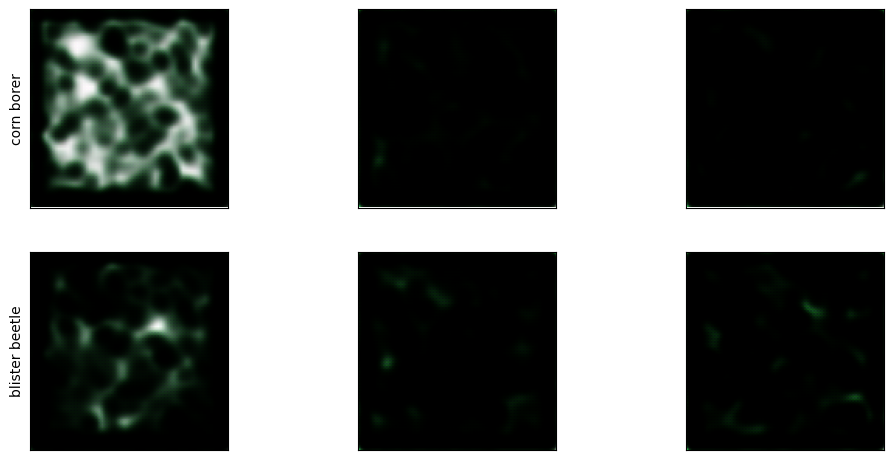

Epoch: 0 -- Generator Loss: 0.6969684362411499, Discriminator Loss: 1.2708051204681396

Took 25.492782592773438 seconds. 


Epoch:  200


56it [00:18,  3.02it/s]


Epoch: 1 -- Generator Loss: 0.6985666155815125, Discriminator Loss: 1.3930385112762451

Took 18.85727572441101 seconds. 


Epoch:  200


56it [00:18,  3.00it/s]


Epoch: 2 -- Generator Loss: 0.6948928833007812, Discriminator Loss: 1.3865464925765991

Took 18.992916345596313 seconds. 


Epoch:  200


56it [00:19,  2.94it/s]


Epoch: 3 -- Generator Loss: 0.6949449181556702, Discriminator Loss: 1.386820912361145

Took 19.383859634399414 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 4 -- Generator Loss: 0.6939941644668579, Discriminator Loss: 1.3866198062896729

Took 19.470040321350098 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 5 -- Generator Loss: 0.6959956288337708, Discriminator Loss: 1.386511206626892

Took 19.39885401725769 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 6 -- Generator Loss: 0.6959938406944275, Discriminator Loss: 1.3864591121673584

Took 19.435649871826172 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 7 -- Generator Loss: 0.6948400139808655, Discriminator Loss: 1.3864132165908813

Took 19.414884567260742 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 8 -- Generator Loss: 0.6953559517860413, Discriminator Loss: 1.385906457901001

Took 19.44100260734558 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 9 -- Generator Loss: 0.6955733895301819, Discriminator Loss: 1.3867501020431519

Took 19.58686327934265 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


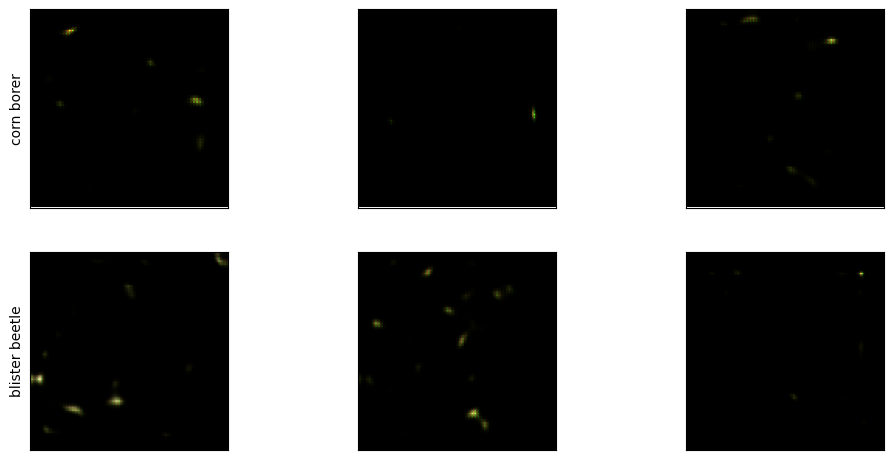

Epoch: 10 -- Generator Loss: 0.6955851316452026, Discriminator Loss: 1.3868032693862915

Took 19.835122108459473 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 11 -- Generator Loss: 0.6956096887588501, Discriminator Loss: 1.3861342668533325

Took 19.480382680892944 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 12 -- Generator Loss: 0.6952099204063416, Discriminator Loss: 1.386492371559143

Took 19.51607036590576 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 13 -- Generator Loss: 0.6952639222145081, Discriminator Loss: 1.3860090970993042

Took 19.503493070602417 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 14 -- Generator Loss: 0.6954678297042847, Discriminator Loss: 1.3860617876052856

Took 19.589303016662598 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 15 -- Generator Loss: 0.6955083012580872, Discriminator Loss: 1.386191725730896

Took 19.51736044883728 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 16 -- Generator Loss: 0.6947369575500488, Discriminator Loss: 1.3868149518966675

Took 19.4343523979187 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 17 -- Generator Loss: 0.6957806348800659, Discriminator Loss: 1.385820984840393

Took 19.5393123626709 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 18 -- Generator Loss: 0.6945198774337769, Discriminator Loss: 1.387332558631897

Took 19.525617122650146 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 19 -- Generator Loss: 0.6952872276306152, Discriminator Loss: 1.3861418962478638

Took 19.587369918823242 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


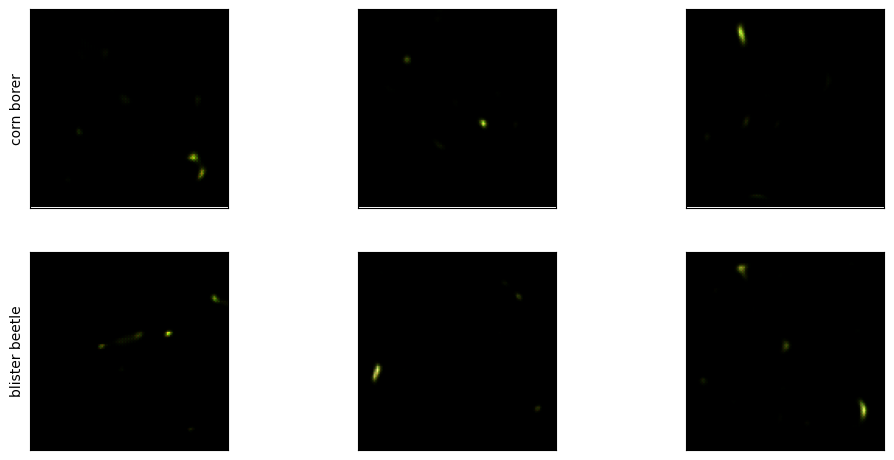

Epoch: 20 -- Generator Loss: 0.6956924796104431, Discriminator Loss: 1.3861585855484009

Took 19.810810327529907 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 21 -- Generator Loss: 0.6953763961791992, Discriminator Loss: 1.3860905170440674

Took 19.56475830078125 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 22 -- Generator Loss: 0.6952981352806091, Discriminator Loss: 1.386190414428711

Took 19.535573482513428 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 23 -- Generator Loss: 0.6951507329940796, Discriminator Loss: 1.3864786624908447

Took 19.563809394836426 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 24 -- Generator Loss: 0.6954489350318909, Discriminator Loss: 1.3857096433639526

Took 19.674512147903442 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 25 -- Generator Loss: 0.6954723000526428, Discriminator Loss: 1.3866264820098877

Took 19.557772397994995 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 26 -- Generator Loss: 0.6948710680007935, Discriminator Loss: 1.3857536315917969

Took 19.567676067352295 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 27 -- Generator Loss: 0.6953815817832947, Discriminator Loss: 1.386871576309204

Took 19.557255506515503 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 28 -- Generator Loss: 0.6953421831130981, Discriminator Loss: 1.3862823247909546

Took 19.619458198547363 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 29 -- Generator Loss: 0.6950292587280273, Discriminator Loss: 1.3864094018936157

Took 19.591899394989014 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


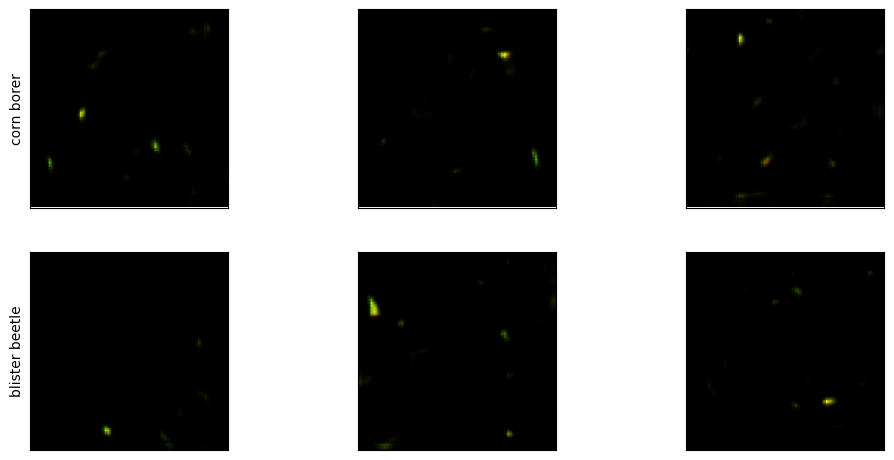

Epoch: 30 -- Generator Loss: 0.6952658891677856, Discriminator Loss: 1.385719895362854

Took 19.88667917251587 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 31 -- Generator Loss: 0.6948650479316711, Discriminator Loss: 1.3860522508621216

Took 19.596747636795044 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 32 -- Generator Loss: 0.6946789622306824, Discriminator Loss: 1.386392593383789

Took 19.633392572402954 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 33 -- Generator Loss: 0.6958536505699158, Discriminator Loss: 1.389121174812317

Took 19.67502737045288 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 34 -- Generator Loss: 0.695800244808197, Discriminator Loss: 1.3863517045974731

Took 19.620532751083374 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 35 -- Generator Loss: 0.6954994201660156, Discriminator Loss: 1.3863451480865479

Took 19.466619729995728 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 36 -- Generator Loss: 0.6962379217147827, Discriminator Loss: 1.387284278869629

Took 19.451478242874146 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 37 -- Generator Loss: 0.695599377155304, Discriminator Loss: 1.38604736328125

Took 19.523159980773926 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 38 -- Generator Loss: 0.6949509382247925, Discriminator Loss: 1.3861846923828125

Took 19.466671228408813 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 39 -- Generator Loss: 0.6949366927146912, Discriminator Loss: 1.3859570026397705

Took 19.589580535888672 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


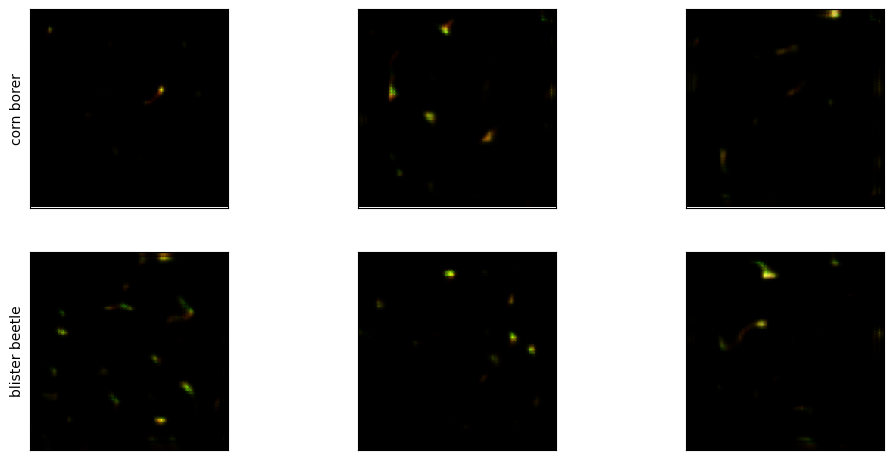

Epoch: 40 -- Generator Loss: 0.6950032114982605, Discriminator Loss: 1.3861043453216553

Took 19.801429748535156 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 41 -- Generator Loss: 0.6950408220291138, Discriminator Loss: 1.3859586715698242

Took 19.409094095230103 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 42 -- Generator Loss: 0.6949690580368042, Discriminator Loss: 1.386139154434204

Took 19.428722143173218 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 43 -- Generator Loss: 0.6952574849128723, Discriminator Loss: 1.3857581615447998

Took 19.565341234207153 seconds. 


Epoch:  200


56it [00:19,  2.88it/s]


Epoch: 44 -- Generator Loss: 0.6949073076248169, Discriminator Loss: 1.3856877088546753

Took 19.75959038734436 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 45 -- Generator Loss: 0.6951045989990234, Discriminator Loss: 1.3856974840164185

Took 19.65384316444397 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 46 -- Generator Loss: 0.6949144005775452, Discriminator Loss: 1.386086106300354

Took 19.712230920791626 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 47 -- Generator Loss: 0.6954109072685242, Discriminator Loss: 1.385970115661621

Took 19.712652921676636 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 48 -- Generator Loss: 0.694502055644989, Discriminator Loss: 1.3860828876495361

Took 19.63556456565857 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 49 -- Generator Loss: 0.6954359412193298, Discriminator Loss: 1.3860456943511963

Took 19.613868951797485 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


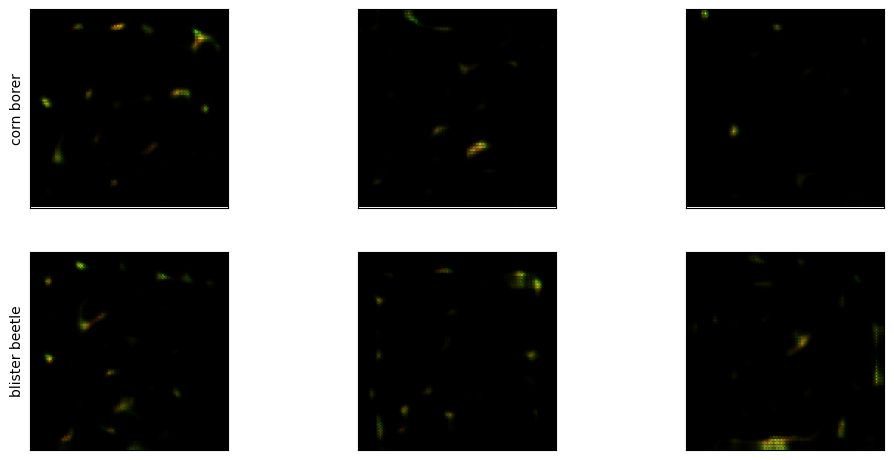

Epoch: 50 -- Generator Loss: 0.6949265599250793, Discriminator Loss: 1.3858636617660522

Took 19.870238065719604 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 51 -- Generator Loss: 0.6950216889381409, Discriminator Loss: 1.386078119277954

Took 19.930181980133057 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 52 -- Generator Loss: 0.6943376660346985, Discriminator Loss: 1.3857587575912476

Took 19.693005800247192 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 53 -- Generator Loss: 0.6954510807991028, Discriminator Loss: 1.3859529495239258

Took 19.62244701385498 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 54 -- Generator Loss: 0.6945610046386719, Discriminator Loss: 1.3857344388961792

Took 19.644516229629517 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 55 -- Generator Loss: 0.6936555504798889, Discriminator Loss: 1.387196660041809

Took 19.62767243385315 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 56 -- Generator Loss: 0.862909734249115, Discriminator Loss: 1.9818699359893799

Took 19.637131214141846 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 57 -- Generator Loss: 0.695622444152832, Discriminator Loss: 1.3871729373931885

Took 19.644331693649292 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 58 -- Generator Loss: 0.6966957449913025, Discriminator Loss: 1.3868920803070068

Took 19.672594785690308 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 59 -- Generator Loss: 0.6962367296218872, Discriminator Loss: 1.3850953578948975

Took 19.682863473892212 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


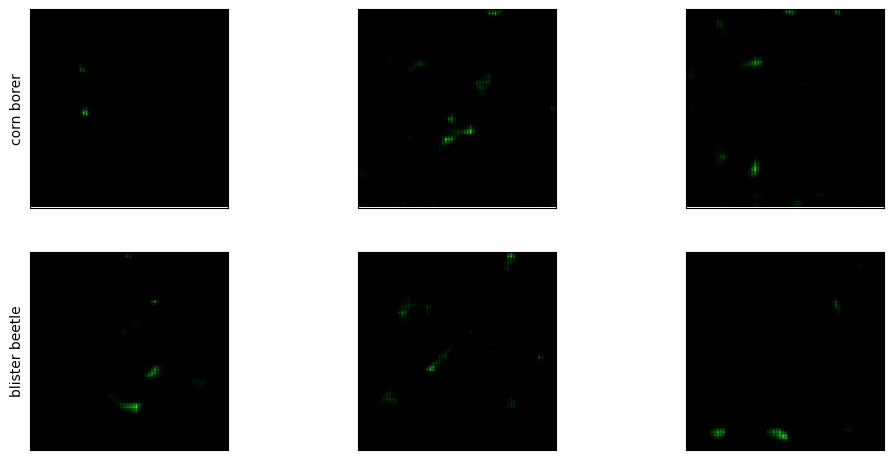

Epoch: 60 -- Generator Loss: 0.6966947913169861, Discriminator Loss: 1.3851803541183472

Took 19.98850679397583 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 61 -- Generator Loss: 0.6965498924255371, Discriminator Loss: 1.385246992111206

Took 19.615764379501343 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 62 -- Generator Loss: 0.6963170766830444, Discriminator Loss: 1.384110450744629

Took 19.6554913520813 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 63 -- Generator Loss: 0.6971705555915833, Discriminator Loss: 1.3850557804107666

Took 19.689950227737427 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 64 -- Generator Loss: 0.6979465484619141, Discriminator Loss: 1.3843183517456055

Took 19.65533185005188 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 65 -- Generator Loss: 0.6966825127601624, Discriminator Loss: 1.3858726024627686

Took 19.665052890777588 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 66 -- Generator Loss: 0.6963708996772766, Discriminator Loss: 1.3829972743988037

Took 19.66969609260559 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 67 -- Generator Loss: 0.6979330778121948, Discriminator Loss: 1.3860538005828857

Took 19.624967098236084 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 68 -- Generator Loss: 0.6968604326248169, Discriminator Loss: 1.38288414478302

Took 19.680761575698853 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 69 -- Generator Loss: 0.69691002368927, Discriminator Loss: 1.3828394412994385

Took 19.715852737426758 seconds. 


Epoch:  200


56it [00:19,  2.88it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


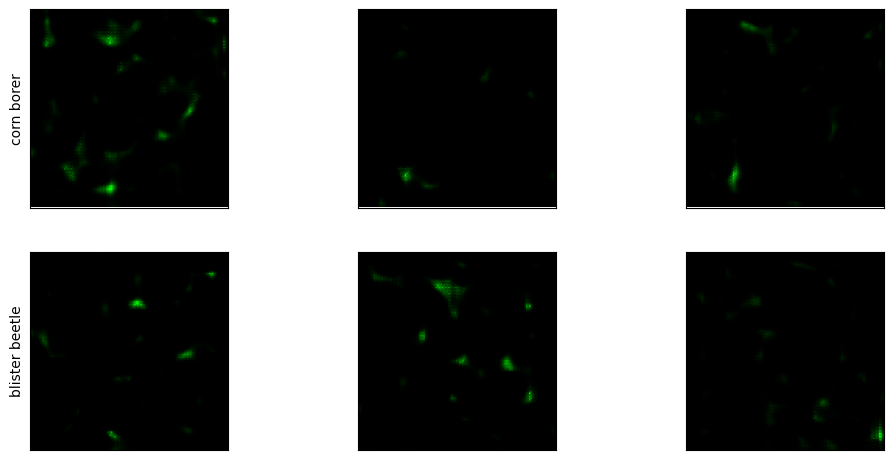

Epoch: 70 -- Generator Loss: 0.6979647278785706, Discriminator Loss: 1.384380578994751

Took 20.02450919151306 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 71 -- Generator Loss: 0.6980417370796204, Discriminator Loss: 1.3831804990768433

Took 19.651247262954712 seconds. 


Epoch:  200


56it [00:19,  2.88it/s]


Epoch: 72 -- Generator Loss: 0.6986821293830872, Discriminator Loss: 1.389974594116211

Took 19.74851942062378 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 73 -- Generator Loss: 0.6966341137886047, Discriminator Loss: 1.3822879791259766

Took 19.687823057174683 seconds. 


Epoch:  200


23it [00:07,  2.89it/s]

In [ ]:
def train(dataset, epochs=epoch_count):

    for epoch in range(epochs):
        print('Epoch: ', epochs)
        d_loss_list = []
        g_loss_list = []
        q_loss_list = []
        start = time.time()
        
        itern = 0
        for image_batch in tqdm(dataset):
            real_images, real_labels = image_batch
            d_loss, g_loss = train_step(image_batch)
            d_loss_list.append(d_loss)
            g_loss_list.append(g_loss)
            itern=itern+1
        if epoch % 10 == 0:
            show_samples(3, n_class, g_model)
            
        print (f'Epoch: {epoch} -- Generator Loss: {np.mean(g_loss_list)}, Discriminator Loss: {np.mean(d_loss_list)}\n')
        print (f'Took {time.time()-start} seconds. \n\n')


dic = f"GAN_result/{str(datetime.datetime.today())}"
os.mkdir(dic)
basic_info = {"batch_size": batch_size, "image_size":img_size, "epoch": epoch_count, "noise_dim":noise_dim, "n_class":n_class}

keys = basic_info.keys()
rows = basic_info.values()

with open(f"{dic}/basic_info.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(keys)
    writer.writerows([rows])


train(dataset, epochs=epoch_count)

g_model.save(f"{dic}/generator.h5")
d_model.save(f"{dic}/discriminator.h5")   